In [250]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import math
import pprint

# 4. High-Time Resolution Failing of the LN Model

In [168]:
# 1. load the data
d = loadmat('LGN_FFdata.mat')

spiks = d['FFspks'][0].flatten() # number is number of seconds from the start for that spike
stims = d['FFstim'].flatten() # the stimlus value at the time step
dt = d['DTstim'][0].flatten() # time between each stimulus

In [169]:
# 1a. scale the spiks by 8, in order to use 1/8 the stimulus resolution
stims8 = np.array([[stim]*8 for stim in stims]).flatten()
dt8 = dt / 8.

In [193]:
# bin the spiks by their associated stims
def associate_spiks_to_stims(spiks, stims, dt):
    max_stim = len(stims) * dt
    # put a tiny amount of extra time at the end of the bin to make sure that we include the extreme times
    epsilon = dt / 2
    return np.histogram(spiks, bins=np.arange(0, max_stim+epsilon, dt), range=(0, max_stim))[0]


# combine the spiks and stims by as columns
def merge_spiks_and_stims(spiks, stims, dt):
    spiks_per_stim = associate_spiks_to_stims(spiks, stims, dt)
    return np.column_stack([stims.flatten(), spiks_per_stim])


# shifts vector by the amount (shift can be positive or negative)
# fills the empty elements with zeros
def shift_vector(vector, shift):
    if shift > len(vector):
        shift = len(vector)
    elif shift < 0 and abs(shift) > len(vector):
        shift = -len(vector)
    
    if shift > 0:
        shifted = np.concatenate((np.zeros((shift)), vector[:-shift]), axis=None)
    elif shift < 0:
        shifted = np.concatenate((vector[abs(shift):], np.zeros((abs(shift)))), axis=None)
    else:
        shifted = vector
    
    return shifted


def calc_sta(merged, num_lags):
    sta = []
    for lag in range(0, num_lags):
        lagged_stim = shift_vector(merged[:,0], lag)
        sta.append(np.sum(lagged_stim * merged[:,1]) / np.sum(merged[:,1]))
    sta = np.array(sta)
    return sta


def g_convolve(s, k):
    # pad to make causal
    k2 = np.zeros(len(k)*2-1)
    k2[len(k)-1:] = [i for i in k] # reverse the kernel before convolving it with s
    g = np.convolve(s, k2, mode='same')
    return g


def nl_func(nl, g_stim):
    x = np.arange(-6, 6, 0.2)
    # find the closest nl value for the given g_stim
    for i in range(len(x)-1):
        if g_stim >= x[i] and g_stim < x[i+1]:
            return nl[i]
    return -1

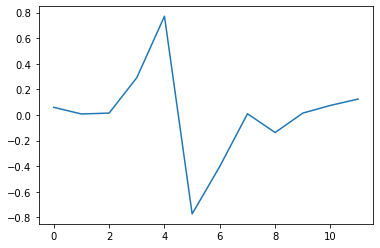

In [184]:
# 2. calculate the STA for the neuron --> g()
merged = merge_spiks_and_stims(spiks, stims, dt)
sta = calc_sta(merged, num_lags=12)
plt.plot(sta)

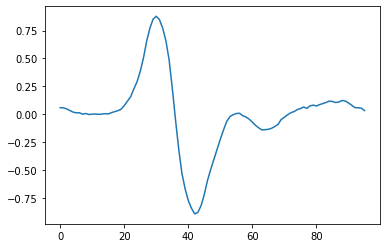

In [185]:
# 2. calculate the STA for the neuron --> g()
merged8 = merge_spiks_and_stims(spiks, stims8, dt8)
sta8 = calc_sta(merged8, num_lags=12*8)
plt.plot(sta8)

In [138]:
# 3. calculate the spiking nonlinearity function --> r()
g8 = g_convolve(stims8, sta8)

# normalize g by the std dev of g and then recompute the filter responses over the stimulus
g8 = sta8 / np.std(g8)
g8 = g_convolve(stims8, g8)

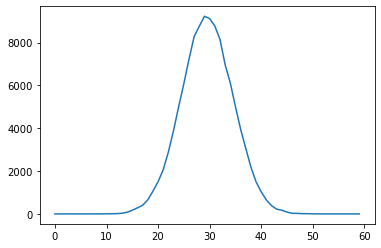

In [139]:
histg8 = np.histogram(g8, bins=np.arange(-6, 6.2, 0.2))[0]
plt.plot(histg8)

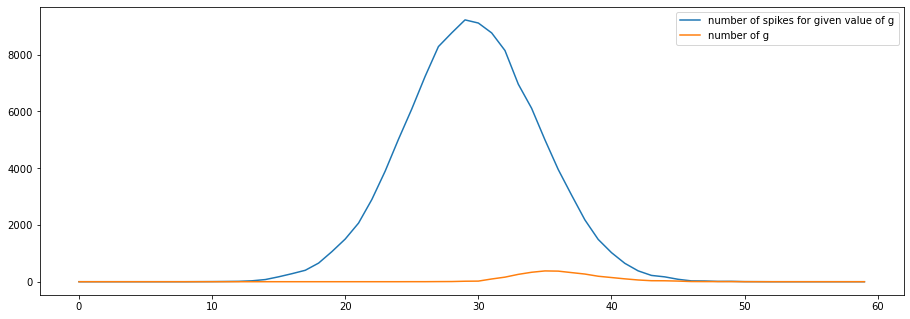

In [140]:
# filter the filtered_stims for just when there is a spike
indices_when_spiking = (merged8[:,1] > 0).nonzero()[0]

# NOTE: this is wrong, we don't just want g(stim) when there is a spike,
#       we want to multiply the value of g by the number of spikes
filtered_stims_when_spiking8 = g8[indices_when_spiking]
histg8_spiking = np.histogram(filtered_stims_when_spiking8, bins=np.arange(-6, 6.2, 0.2))[0]

axc = plt.axes([1, 1, 2, 1])
axc.plot(histg8, label='number of spikes for given value of g')
axc.plot(histg8_spiking, label='number of g')
axc.legend()
plt.show()

/var/folders/rc/lxb7w_kn1gd1gppq2y1hq2tm0000gn/T/ipykernel_12451/902925586.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(histg8_spiking / histg8)


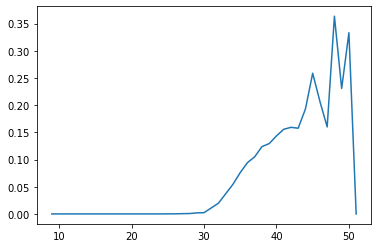

In [141]:
plt.plot(histg8_spiking / histg8)

In [142]:
# 4. predict the rate from the cascade model r(g(stim))

In [149]:
# the stims are the same for each trial
stimsr = d['FFstimR'][:,0]
stimsr8 = np.array([[stim]*8 for stim in stimsr]).flatten() # stretch the stims by 8
len(stimsr), len(stimsr8)/8

(1200, 1200.0)

In [150]:
# split the trials into rows, using -1 as the flag variable
spiksr = []
spikr = []
for x in d['FFspksR'][0]:
    if x == -1:
        spiksr.append(np.array(spikr))
        spikr = []
        continue
    spikr.append(x)

In [152]:
# merge the stimsr and spiksr for each trial
mergedrs8 = []
for spiks in spiksr:
    mergedrs8.append(merge_spiks_and_stims(spiks, stimsr8, dt8))
mergedrs8 = np.array(mergedrs)

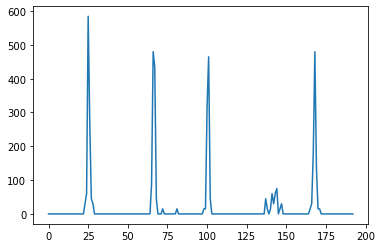

In [153]:
# calculate the neurons firing rate as a function of time, using a bin size DTstim
# r(t) = n_spk(t) / dt
# sum over the columns and divide by dt
rate_t8 = [np.mean(mergedr8) for mergedr8 in mergedrs8[:,:,1].T] / dt8
# plot the firing rate between 800ms and 1000ms, vertical axis units in Hz
plt.plot(rate_t8[math.floor(.8/dt8):math.ceil(1/dt8)])

In [155]:
# 3. calculate the spiking nonlinearity function --> r()
g8 = g_convolve(stimsr8, sta8)

# normalize g by the std dev of g and then recompute the filter responses over the stimulus
g8 = sta / np.std(g8)
g8 = g_convolve(stimsr8, g8)
filtered_stimsr8 = g8

In [156]:
nl = histg8_spiking / histg8
nl = np.array(list(map(lambda x: x if not np.isnan(x) else 0, nl))) # remove the NaNs from nl

/var/folders/rc/lxb7w_kn1gd1gppq2y1hq2tm0000gn/T/ipykernel_12451/4113816606.py:1: RuntimeWarning: invalid value encountered in true_divide
  nl = histg8_spiking / histg8


794.4492339854968


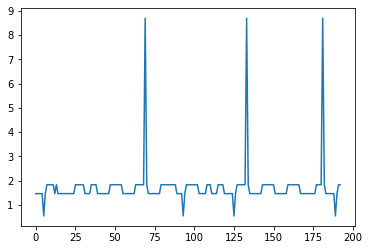

In [165]:
# get the probability of a spike at each stimulus presentation
pred_prob_t8 = np.array(list(map(nl_func, filtered_stimsr8)))

# multiply this by the max number of spikes to change this to Hz
max_num_spikes = np.max(rate_t8)
print(max_num_spikes)

pred_t8 = pred_prob_t8 * max_num_spikes

# plot it
plt.plot(pred_t[math.floor(.8/dt8):math.ceil(1/dt8)])

In [167]:
r2 = 1 - (np.var(rate_t8 - pred_t8) / np.var(rate_t8))
r2

0.0001970739550608558

In [378]:
# do experiment for different time resolutions and plot the r2 at each time resolution

def train(_stims, _spiks, _dt, time_scale=1):
    # 1. scale the stims and dt by the time_scale
    spiks = _spiks # spiks do not need to be scaled, they are already in ms
    stims = np.array([[_stim]*time_scale for _stim in _stims]).flatten()
    dt = _dt / float(time_scale)
    
    
    # 2. calculate the unnormalized STA for the neuron
    merged = merge_spiks_and_stims(spiks, stims, dt)
    sta = calc_sta(merged, num_lags=12*time_scale) # 12 lags for time_scale==1, otherwise adjust that
    spike_rate = merged[:,1].T / dt
    max_spike_rate = np.max(spike_rate)
    
    
    # 3. convolve the stims with the sta and normalize to generate g --> g()
    g = g_convolve(stims, sta)
    # normalize g by the std dev of g and then recompute the filter responses over the stimulus
    g_std = np.std(g)
    g = sta / g_std
    g = g_convolve(stims, g)
    
    histg = np.histogram(g, bins=np.arange(-6, 6.2, 0.2))[0]
    
    # 4. calculate the spiking nonlinearity function --> r()
    # filter the filtered_stims for just when there is a spike
    indices_when_spiking = (merged[:,1] > 0).nonzero()[0]
    
    # TODO: this is wrong, we don't just want g(stim) when there is a spike,
    #       we want to multiply the value of g by the number of spikes
    # TODO: don't hard code this range, it should probably be dependent on the time scale
    histg_spiking = np.histogram(g[indices_when_spiking], bins=np.arange(-6, 6.2, 0.2))[0]
    
    nl = histg_spiking / histg
    nl = np.array(list(map(lambda x: x if not np.isnan(x) else 0, nl))) # remove the NaNs from nl

    
    # return the trained sta, nl, std, and max_spike_rate
    return sta, nl, g_std, max_spike_rate

In [402]:
def test(sta, nl, g_std, max_spike_rate, _test_stims, _test_spiks, _dt, time_scale=1):
    # 0. stretch the test_stims by the time scale
    test_stims = np.array([[_stim]*time_scale for _stim in _test_stims]).flatten()
    test_spiks = _test_spiks # spiks do not need to be scaled, they are already in ms
    dt = _dt / float(time_scale)
    
    
    # 1. apply the sta to the test_stims --> g(stim)
    g = g_convolve(test_stims, sta)

    # TODO: do I need to do this again like this?
    # normalize g by the std dev of the training g and then recompute the filter responses over the stimulus
    g = sta / g_std
    g = g_convolve(test_stims, g)
    
    
    # 2. get the probability of a spike at each stimulus presentation --> r(g(stim))
    pred_probs = np.array([nl_func(nl, val) for val in g])

    test_merged = np.array([merge_spiks_and_stims(test_spik, test_stims, dt) for test_spik in test_spiks])
    actual_rates = [np.mean(val) for val in test_merged[:,:,1].T] / dt
    
    # multiply this by the max number of spikes to change this to Hz
    #pred_rates = pred_probs * max_spike_rate
    pred_rates = pred_probs * np.max(actual_rates)
    
    # return predicted vs. actual
    return pred_rates, actual_rates

In [403]:
# load the data
d = loadmat('LGN_FFdata.mat')

train_spiks = d['FFspks'][0].flatten() # number is number of seconds from the start for that spike
train_stims = d['FFstim'].flatten() # the stimlus value at the time step
dt = d['DTstim'][0].flatten() # time between each stimulus

# the stims are the same for each trial
test_stims = d['FFstimR'][:,0]
# split the trials into rows, using -1 as the flag variable
test_spiks = []
test_spik = []
for x in d['FFspksR'][0]:
    if x == -1:
        test_spiks.append(np.array(test_spik))
        test_spik = []
        continue
    test_spik.append(x)
# to avoid missing the final trial, add it at the end
test_spiks.append(test_spik)

/var/folders/rc/lxb7w_kn1gd1gppq2y1hq2tm0000gn/T/ipykernel_12451/3658108609.py:35: RuntimeWarning: invalid value encountered in true_divide
  nl = histg_spiking / histg


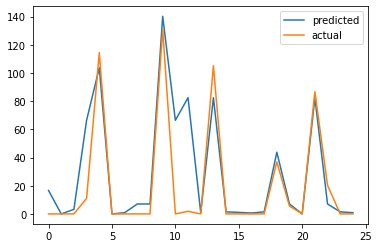

0.5684893933903946


In [406]:
# train and test the model
TIME_SCALE = 1

sta, nl, g_std, max_spike_rate = train(stims, spiks, dt, time_scale=TIME_SCALE)
pred_rates, actual_rates = test(sta, nl, g_std, max_spike_rate, test_stims, test_spiks, dt, time_scale=TIME_SCALE)
plt.plot(pred_rates[math.floor(.8/dt):math.ceil(1/dt)], label='predicted')
plt.plot(actual_rates[math.floor(.8/dt):math.ceil(1/dt)], label='actual')
plt.legend()
plt.show()

r2 = 1 - (np.var(actual_rates - pred_rates) / np.var(actual_rates))
print(r2)

/var/folders/rc/lxb7w_kn1gd1gppq2y1hq2tm0000gn/T/ipykernel_12451/3658108609.py:35: RuntimeWarning: invalid value encountered in true_divide
  nl = histg_spiking / histg


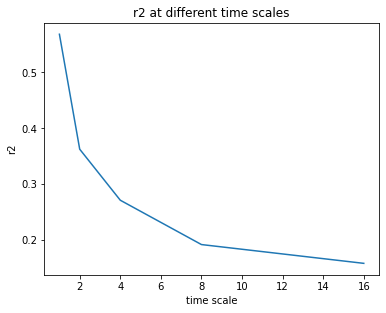

In [422]:
time_scales = [1, 2, 4, 8, 16]
r2s = []
for ts in time_scales:
    sta, nl, g_std, max_spike_rate = train(stims, spiks, dt, time_scale=ts)
    pred_rates, actual_rates = test(sta, nl, g_std, max_spike_rate, test_stims, test_spiks, dt, time_scale=ts)
    r2 = 1 - (np.var(actual_rates - pred_rates) / np.var(actual_rates))
    r2s.append(r2)

fig = plt.figure()
fig.subplots_adjust(top=1)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('time scale')
ax1.set_ylabel('r2')
ax1.set_title('r2 at different time scales')
ax1.plot(time_scales, r2s)

In [423]:
dt

array([0.00833911])